# Title: csck700_bsdd_enrichment

### The bsdd_enrichment Python module queries the buildingSMART Data Dictionary (bSDD) API to retrieve canonical metadata for technical properties and ensures semantic alignment. It creates extended property sets when not present in the IFC database and links new properties to them, or, when property sets already exist, it connects the enriched properties directly to the corresponding IfcPropertySet in the graph.

In [1]:
from IPython.display import Image, display

In [2]:
picture_path = r"..\references\graph_enrichment_layer.jpg"

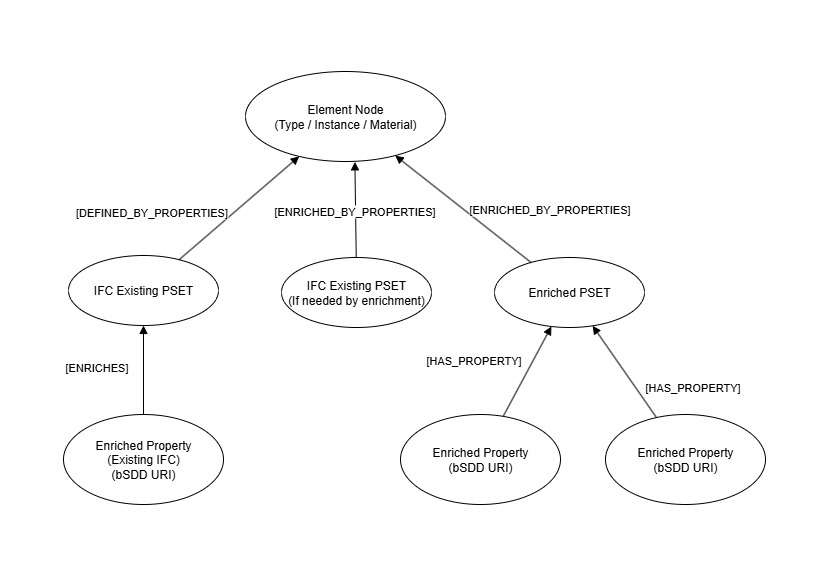

In [3]:
display(Image(filename=picture_path))

# 0. Table of content:

- [1. Settings:](#1.-Settings:)
- [2. Imports:](#2.-Imports:)
- [3. Helper functions:](#3.-Helper-functions:)
- [4. Data load:](#4.-Data-load:)  
- [5. bsDD preparation:](#5.-bsDD-preparation:)
- [6. Graph enrichment:](#6.-Graph-enrichment:)  

# 1. Settings:

# 2. Imports:

In [4]:
# !pip install pandas
import pandas as pd
# !pip install openpyxl
import openpyxl
import warnings
warnings.simplefilter("ignore", UserWarning)
import requests
import re
# !pip install rapidfuzz
from rapidfuzz import fuzz

# 3. Helper functions:

# 4. Data load:

In [5]:
file_path = r"..\data\raw\1111.xlsx"

In [6]:
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
print(sheet_names)

['description', 'data_validation', 'stone_wall_chimney', 'roof_wood_beam', 'strip_footing', 'beam_shoe']


In [7]:
df_names = sheet_names[2:]

In [8]:
dfs = dict()
for df_name in df_names:
    dfs[df_name] = pd.read_excel(file_path, sheet_name=df_name)

In [9]:
for name, df in dfs.items():
    print(f"\n### Dataframe: {name} ###")
    display(df.head(10))


### Dataframe: stone_wall_chimney ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN



### Dataframe: roof_wood_beam ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beam_001,Roof Wood Beam,IfcBeam,species,douglas fir-larch,=,douglas fir-larch,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
1,beam_002,Roof Wood Beam,IfcBeam,grade,No.1,=,No.1,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
2,beam_003,Roof Wood Beam,IfcBeam,moisture content,≤ 19%,≤,19,%,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
3,beam_004,Roof Wood Beam,IfcBeam,fire retardant treatment,Pass,=,Pass,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,ASTM E84,NaN,NaN,NaN
4,beam_005,Roof Wood Beam,IfcBeam,preservative treatment,CCA,=,CCA,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.2,AWPA U1,NaN,NaN,NaN
5,beam_007,Roof Wood Beam,IfcBeam,straightness tolerance,"Lumber shall be free from bow, crook, twist, a...",enum,"{""bow_mm_per_2.4m"": 6, ""crook_mm_per_2.4m"": 6,...",NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,WWPA / NLGA,NaN,NaN,NaN
6,beam_008,Roof Wood Beam,IfcBeam,bending strength,11.0 Mpa,=,11,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
7,beam_009,Roof Wood Beam,IfcBeam,elastic modulus,"12,400 Mpa",=,12400,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§2.1,NaN,NaN,NaN,NaN
8,beam_010,Roof Wood Beam,IfcBeam,bearing length,≥ 90 mm,≥,90,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN
9,beam_011,Roof Wood Beam,IfcBeam,spacing (on center),600 mm,=,600,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 06 10 00,§3,NaN,NaN,NaN,NaN



### Dataframe: strip_footing ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,footing_001,Strip Footing,IfcFooting,compressive strength,28 MPa,=,28,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 01,"§2.5.1, §3.14.3.4",ASTM C39,NaN,NaN,NaN
1,footing_002,Strip Footing,IfcFooting,slump,75 ± 25 mm,=,75 ± 25,mm,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.14.3.1,ASTM C143,NaN,NaN,NaN
2,footing_003,Strip Footing,IfcFooting,water cement ratio,0.45,≤,0.45,w/cm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.5.2.6,"ACI 211.1, ACI 211.2",NaN,NaN,NaN
3,footing_004,Strip Footing,IfcFooting,nominal maximum aggregate size,25 mm,≤,25,mm,Material,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.3.3.1,ASTM C33,NaN,NaN,NaN
4,footing_006,Strip Footing,IfcFooting,rebar grade,grade 60,=,grade 60,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§2.6.1,ASTM A615,NaN,NaN,NaN
5,footing_007,Strip Footing,IfcFooting,rebar coating,uncoated,=,uncoated,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,"§2.6.1.1, §2.6.1.4",ASTM A615,NaN,NaN,NaN
6,footing_008,Strip Footing,IfcFooting,concrete cover to rebar,≥ 75 mm,≥,75,mm,Type,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.5.12,ACI 318,NaN,NaN,NaN
7,footing_009,Strip Footing,IfcFooting,dimensional tolerances,25 mm,=,25,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.3.8,ACI 117,NaN,NaN,NaN
8,footing_010,Strip Footing,IfcFooting,surface finish,standard smooth finish,=,standard smooth finish,NaN,Type,True,...,NaN,NaN,NaN,NaN,UFGS 03 30 00,§3.9.3.3,ACI 301,NaN,NaN,NaN



### Dataframe: beam_shoe ###


,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,beamshoe_001,Beam Shoe,IfcDiscreteAccessory,base material,stainless steel bars and shapes Type 304,=,Type 304,NaN,Material,True,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.1,ASTM A276/A276M,NaN,NaN,NaN
1,beamshoe_002,Beam Shoe,IfcDiscreteAccessory,corrosion protection,hot-dip galvanize items,=,Z275 (G90),NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.3.1,ASTM A123/A153,NaN,NaN,NaN
2,beamshoe_003,Beam Shoe,IfcDiscreteAccessory,anchor bolts,anchor bolts,=,55,ksi,Type,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§2.2.8,ASTM F1554,NaN,NaN,NaN
3,beamshoe_004,Beam Shoe,IfcDiscreteAccessory,dissimilar metal protection,dissimilar metals,=,MPI 79,NaN,Type,False,...,NaN,NaN,NaN,NaN,UFGS 05 50 13,§3.6,ASTM D1187,NaN,NaN,NaN


# 5. bsDD preparation:

## 5.1. bsDD client - REST:

### 5.1.1. IFC 4.3. dictionary correspondance:

In [10]:
BASE = "https://api.bsdd.buildingsmart.org"
IFC43 = "https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3"
ETIM = "https://identifier.buildingsmart.org/uri/etim/etim/10.0"
HEADERS = {
    "accept": "application/json",
    "user-agent": "BenoitCapstone/1.0"
}
TIMEOUT = 12

In [11]:
def _get(path, params):
    
    r = requests.get(f"{BASE}{path}", params=params, headers=HEADERS, timeout=TIMEOUT)
    r.raise_for_status()
    
    return r.json()

In [12]:
cls = "https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcWall"
params = {"ClassUri": cls}
path = "/api/Class/Properties/v1"
dico = _get(path, params)

In [13]:
properties = dico.get("classProperties")
properties

[{'name': 'Description',
  'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcWall/prop/Attributes/Description',
  'description': 'Optional description, provided for exchanging informative comments.',
  'definition': 'Optional description, provided for exchanging informative comments.',
  'dataType': 'String',
  'propertyCode': 'Description',
  'propertyDictionaryName': 'IFC',
  'propertyDictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
  'propertyUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Description',
  'propertySet': 'Attributes',
  'propertyStatus': 'Active',
  'propertyValueKind': 'Single'},
 {'name': 'Element Type',
  'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcWall/prop/Attributes/ElementType',
  'description': "The type denotes a particular type that indicates the object further. The use has to be established at the level of instantiable subtypes. In 

In [14]:
len(properties)

233

In [15]:
def normalize(s):
    return re.sub(r"[^a-z0-9]", " ", s.lower()).split()

In [16]:
def get_pset_uri(pset_name):
    
    data = _get(
        "/api/TextSearch/v2",
        params = {
            "SearchText": pset_name,
            "DictionaryUris": [IFC43],
            "TypeFilter": "GroupOfProperties",
            "IncludeInactive": True,
            "IncludePreview": True
        })

    # print(data)
    
    for item in data.get("classes", []):
        if item.get("classType") == "GroupOfProperties":
            return item.get("code"), item.get("uri")
    return None, None
    

In [17]:
get_pset_uri("Pset_WallCommon")

('Pset_WallCommon',
 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/Pset_WallCommon')

In [19]:
# matching = set()
# for p in properties:
#     if is_match("Description", p["name"]):
#         matching.add(p["name"])

# matching

In [20]:
list(matching)

[]

In [21]:
df_asset = dfs["stone_wall_chimney"]
df_asset

,id,asset_type,ifc_class,parameter_name_input,value_raw,operator,value_normalized,unit,target_label,ifc_exists,...,bsdd_property_uri,bsdd_label,bsdd_dictionary_code,bsdd_version,source_doc,source_clause,value_standard,mapping_confidence,roundtrip_action,notes
0,stone_001,Stone Wall,IfcWall;IfcChimney,absorption,≤ 7.5 %,≤,7.5,%,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
1,stone_002,Stone Wall,IfcWall;IfcChimney,bulk specific gravity,≥ 2.16 g/cm³,≥,2.16,g/cm³,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C97,NaN,NaN,NaN
2,stone_003,Stone Wall,IfcWall;IfcChimney,modulus of rupture,≥ 7 MPa,≥,7,MPa,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C99,NaN,NaN,NaN
3,stone_004,Stone Wall,IfcWall;IfcChimney,flexural strength,≥ 7 MPa,≥,7,MPa,Material,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C880,NaN,NaN,NaN
4,stone_005,Stone Wall,IfcWall;IfcChimney,weathering classification,= suitable for exterior use,=,suitable for exterior use,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C568 / C616,NaN,NaN,NaN
5,stone_006,Stone Wall,IfcWall;IfcChimney,resistance to freezing and thawing,= pass,=,pass,NaN,Material,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,ASTM C666,NaN,NaN,NaN
6,stone_007,Stone Wall,IfcWall;IfcChimney,joint thickness,= 6–10 mm,range,6-10,mm,Type,False,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§3.3,NaN,NaN,NaN,NaN
7,stone_008,Stone Wall,IfcWall;IfcChimney,finish,= smooth machine finish free of tool marks; 4-...,enum,"{smooth machine, 4-cut, 6-cut, equivalent, fre...",NaN,Type,True,...,NaN,NaN,NaN,NaN,UFGS 04 20 00,§2.2.5,NaN,NaN,NaN,NaN


**Get class properties:**

In [22]:
def classes_properties(dfs, df_names):
    """
    """
    
    properties_dict = dict()

    for df_name in df_names:
        df_asset = dfs[df_name]
        df_class = df_asset.loc[0,"ifc_class"].split(";")[0]

        # search for class uri:
        data = _get(
        "/api/TextSearch/v2",
        params = {
            "SearchText": df_class,
            "DictionaryUris": [IFC43],
            "TypeFilter": "Class",
            "IncludeInactive": True,
            "IncludePreview": True
        })
        classes = data.get("classes", []) or []

        cls_uri = None
        for cls in classes:
            if cls.get("code") == df_class:
                cls_uri = cls.get("uri")
                break

        if not cls_uri:
                print(f"[WARN] Could not resolve URI for class '{df_class}'")
                continue

        # search flor class properties:
        params = {"ClassUri": cls_uri}
        path = "/api/Class/Properties/v1"
        dico = _get(path, params)
        properties = dico.get("classProperties", []) or []

        properties_dict[df_class] = properties

    return properties_dict

In [23]:
properties_dict = classes_properties(dfs, df_names)
properties_dict

{'IfcWall': [{'name': 'Description',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcWall/prop/Attributes/Description',
   'description': 'Optional description, provided for exchanging informative comments.',
   'definition': 'Optional description, provided for exchanging informative comments.',
   'dataType': 'String',
   'propertyCode': 'Description',
   'propertyDictionaryName': 'IFC',
   'propertyDictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'propertyUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/Description',
   'propertySet': 'Attributes',
   'propertyStatus': 'Active',
   'propertyValueKind': 'Single'},
  {'name': 'Element Type',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcWall/prop/Attributes/ElementType',
   'description': "The type denotes a particular type that indicates the object further. The use has to be established at the level of 

In [24]:
for k, v in properties_dict.items():
    print(k)

IfcWall
IfcBeam
IfcFooting
IfcDiscreteAccessory


**Get matching property:**

In [25]:
def is_match(ufgs_param, bsd_prop, threshold=90):
    # exact ignore-case
    if ufgs_param.strip().lower() == bsd_prop.strip().lower():
        return True
    # substring containment
    if " ".join(normalize(ufgs_param)) in " ".join(normalize(bsd_prop)):
        return True
    # fuzzy score
    if fuzz.ratio(ufgs_param, bsd_prop) >= threshold:
        return True
    return False

In [26]:
for df_name in df_names:
    df_asset = dfs[df_name]
    df_class = df_asset.loc[0,"ifc_class"].split(";")[0]
    asset_properties = list(df_asset.loc[:,"parameter_name_input"])
    # print(df_asset_properties)

    properties = properties_dict[df_class]
    # print(properties)

    for prop in asset_properties:
        print(prop)
        lst = []
        for p in properties:
            p_name = p["name"]
            if is_match(prop, p_name, threshold=90):
                lst.append(p_name)
        print(lst)
            
            

absorption
[]
bulk specific gravity
[]
modulus of rupture
[]
flexural strength
[]
weathering classification
[]
resistance to freezing and thawing
[]
joint thickness
[]
finish
[]
species
[]
grade
[]
moisture content
[]
fire retardant treatment
[]
preservative treatment
[]
straightness tolerance
[]
bending strength
[]
elastic modulus
[]
bearing length
[]
spacing (on center)
[]
compressive strength
[]
slump
[]
water cement ratio
[]
nominal maximum aggregate size
[]
rebar grade
[]
rebar coating
[]
concrete cover to rebar
[]
dimensional tolerances
[]
surface finish
[]
base material
[]
corrosion protection
[]
anchor bolts
[]
dissimilar metal protection
[]


In [27]:
# df_asset = dfs['stone_wall_chimney']
# df_class = df_asset.loc[0,"ifc_class"].split(";")[0]
# asset_properties = list(df_asset.loc[:,"parameter_name_input"])
# # print(df_asset_properties)

# properties = properties_dict[df_class]
#     # print(properties)

# for prop in asset_properties:
lst = []
for p in properties:
    p_name = p["name"]
    if is_match("height", p_name, threshold=90):
        lst.append(p_name)
print(lst)

['Diagonal Truss Height', 'Fixing Socket Height', 'Ladder Truss Height']


In [28]:
properties_names = []
for p in properties_dict["IfcWall"]:
    properties_names.append(p["name"])


In [29]:
properties_names

['Description',
 'Element Type',
 'Global ID',
 'Name',
 'Object Type',
 'Tag',
 'Assembly Place',
 'Casting Method',
 'Concrete Cover',
 'Concrete Cover at Links',
 'Concrete Cover at Main Bars',
 'Construction Tolerance Class',
 'Dimensional Accuracy Class',
 'Exposure Class',
 'Reinforcement Area Ratio',
 'Reinforcement Strength Class',
 'Reinforcement Volume Ratio',
 'Strength Class',
 'Structural Class',
 'Assessment Condition',
 'Assessment Date',
 'Assessment Description',
 'Assessment Frequency',
 'Assessment Method',
 'Assessment Type',
 'Last Assessment Report',
 'Next Assessment Date',
 'Procurement Method',
 'Specification Section Number',
 'Submittal Identifer',
 'Asset Identifier',
 'Installation Date',
 'Model Number',
 'Tag Number',
 'Cyclic Path',
 'Cyclic Range',
 'Linear Path',
 'Linear Range',
 'Maximum Angular Velocity',
 'Maximum Constant Speed',
 'Minimum Time',
 'Maximum Atmospheric Pressure',
 'Maximum Rain Intensity',
 'Maximum Solar Radiation',
 'Maximum Wind

In [30]:
properties_names = []
for p in properties_dict["IfcFooting"]:
    properties_names.append(p["name"])
properties_names

['Description',
 'Element Type',
 'Global ID',
 'Name',
 'Object Type',
 'Tag',
 'Assembly Place',
 'Casting Method',
 'Concrete Cover',
 'Concrete Cover at Links',
 'Concrete Cover at Main Bars',
 'Construction Tolerance Class',
 'Dimensional Accuracy Class',
 'Exposure Class',
 'Reinforcement Area Ratio',
 'Reinforcement Strength Class',
 'Reinforcement Volume Ratio',
 'Strength Class',
 'Structural Class',
 'Assessment Condition',
 'Assessment Date',
 'Assessment Description',
 'Assessment Frequency',
 'Assessment Method',
 'Assessment Type',
 'Last Assessment Report',
 'Next Assessment Date',
 'Procurement Method',
 'Specification Section Number',
 'Submittal Identifer',
 'Asset Identifier',
 'Installation Date',
 'Model Number',
 'Tag Number',
 'Cyclic Path',
 'Cyclic Range',
 'Linear Path',
 'Linear Range',
 'Maximum Angular Velocity',
 'Maximum Constant Speed',
 'Minimum Time',
 'Maximum Atmospheric Pressure',
 'Maximum Rain Intensity',
 'Maximum Solar Radiation',
 'Maximum Wind

In [31]:
properties_names = []
for p in properties_dict["IfcBeam"]:
    properties_names.append(p["name"])
properties_names

['Description',
 'Element Type',
 'Global ID',
 'Name',
 'Object Type',
 'Tag',
 'Fire Rating',
 'Is External',
 'Load Bearing',
 'Roll',
 'Slope',
 'Span',
 'Status',
 'Thermal Transmittance',
 'Assembly Place',
 'Casting Method',
 'Concrete Cover',
 'Concrete Cover at Links',
 'Concrete Cover at Main Bars',
 'Construction Tolerance Class',
 'Dimensional Accuracy Class',
 'Exposure Class',
 'Reinforcement Area Ratio',
 'Reinforcement Strength Class',
 'Reinforcement Volume Ratio',
 'Strength Class',
 'Structural Class',
 'Assessment Condition',
 'Assessment Date',
 'Assessment Description',
 'Assessment Frequency',
 'Assessment Method',
 'Assessment Type',
 'Last Assessment Report',
 'Next Assessment Date',
 'Procurement Method',
 'Specification Section Number',
 'Submittal Identifer',
 'Asset Identifier',
 'Installation Date',
 'Model Number',
 'Tag Number',
 'Cyclic Path',
 'Cyclic Range',
 'Linear Path',
 'Linear Range',
 'Maximum Angular Velocity',
 'Maximum Constant Speed',
 'Min

In [33]:
data = _get(
        "/api/TextSearch/v2",
        params = {
            "SearchText": "compressive strength",
            "DictionaryUris": [IFC43],
            "TypeFilter": "Property",
            "IncludeInactive": True,
            "IncludePreview": True
        })
data

{'classes': [],
 'dictionaries': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'organizationName': 'buildingSMART International',
   'code': 'ifc',
   'name': 'IFC',
   'version': '4.3',
   'status': 'Preview',
   'languages': [{'isoCode': 'EN', 'name': 'English'},
    {'isoCode': 'de-DE', 'name': 'German'},
    {'isoCode': 'es-ES', 'name': 'Spanish'},
    {'isoCode': 'ja-JP', 'name': 'Japanese'},
    {'isoCode': 'nl-NL', 'name': 'Dutch'},
    {'isoCode': 'no-NO', 'name': 'Norwegian'},
    {'isoCode': 'pt-PT', 'name': 'Portuguese'},
    {'isoCode': 'ru-RU', 'name': 'Russian'},
    {'isoCode': 'zh-CN', 'name': 'Chinese'},
    {'isoCode': 'it-IT', 'name': 'Italian'},
    {'isoCode': 'pl-PL', 'name': 'Polish'},
    {'isoCode': 'da-DK', 'name': 'Danish'},
    {'isoCode': 'cs-CZ', 'name': 'Czech'},
    {'isoCode': 'pt-BR', 'name': 'Portuguese (BR)'},
    {'isoCode': 'sv-SE', 'name': 'Swedish'}],
   'isLatestVersion': True,
   'isVerified': True}],
 'propertie

In [36]:
data = _get(
        "/api/Property/Classes/v1",
        params = {
            "PropertyUri": "https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength",
            # "SearchText": "IfcConcrete",
            # # "DictionaryUris": [IFC43],
            # "TypeFilter": "Property",
            # "IncludeInactive": True,
            # "IncludePreview": True
        })
data

{'propertyUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength',
 'propertyClasses': [{'name': 'Material',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcMaterial',
   'description': '[[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).',
   'dictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'propertySet': 'Pset_MaterialConcrete'},
  {'name': 'Material',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcMaterial',
   'description': '[[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).',
   'dictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'propertySet': 'Pset_MechanicalPanelInPlane'},
  {'name': 'Material',
   'uri': 'https://identifier.buildings

## 5.1. Other approach:

In [37]:
def classes_properties(dfs, df_names):
    """
    """
    
    properties_dict = dict()

    for df_name in df_names:
        df_asset = dfs[df_name]
        df_class = df_asset.loc[0,"ifc_class"].split(";")[0]

        properties = list(df_asset["parameter_name_input"])

        properties_dict[df_class] = properties

    return properties_dict

In [38]:
properties_dict = classes_properties(dfs, df_names)
properties_dict

{'IfcWall': ['absorption',
  'bulk specific gravity',
  'modulus of rupture',
  'flexural strength',
  'weathering classification',
  'resistance to freezing and thawing',
  'joint thickness',
  'finish'],
 'IfcBeam': ['species',
  'grade',
  'moisture content',
  'fire retardant treatment',
  'preservative treatment',
  'straightness tolerance',
  'bending strength',
  'elastic modulus',
  'bearing length',
  'spacing (on center)'],
 'IfcFooting': ['compressive strength',
  'slump',
  'water cement ratio',
  'nominal maximum aggregate size',
  'rebar grade',
  'rebar coating',
  'concrete cover to rebar',
  'dimensional tolerances',
  'surface finish'],
 'IfcDiscreteAccessory': ['base material',
  'corrosion protection',
  'anchor bolts',
  'dissimilar metal protection']}

In [52]:
target = "IfcFooting"

In [48]:
data = _get(
        "/api/TextSearch/v2",
        params = {
            "SearchText": "compressive strength",
            "DictionaryUris": [IFC43],
            "TypeFilter": "Property",
            "IncludeInactive": True,
            "IncludePreview": True
        })
data

{'classes': [],
 'dictionaries': [{'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'organizationName': 'buildingSMART International',
   'code': 'ifc',
   'name': 'IFC',
   'version': '4.3',
   'status': 'Preview',
   'languages': [{'isoCode': 'EN', 'name': 'English'},
    {'isoCode': 'de-DE', 'name': 'German'},
    {'isoCode': 'es-ES', 'name': 'Spanish'},
    {'isoCode': 'ja-JP', 'name': 'Japanese'},
    {'isoCode': 'nl-NL', 'name': 'Dutch'},
    {'isoCode': 'no-NO', 'name': 'Norwegian'},
    {'isoCode': 'pt-PT', 'name': 'Portuguese'},
    {'isoCode': 'ru-RU', 'name': 'Russian'},
    {'isoCode': 'zh-CN', 'name': 'Chinese'},
    {'isoCode': 'it-IT', 'name': 'Italian'},
    {'isoCode': 'pl-PL', 'name': 'Polish'},
    {'isoCode': 'da-DK', 'name': 'Danish'},
    {'isoCode': 'cs-CZ', 'name': 'Czech'},
    {'isoCode': 'pt-BR', 'name': 'Portuguese (BR)'},
    {'isoCode': 'sv-SE', 'name': 'Swedish'}],
   'isLatestVersion': True,
   'isVerified': True}],
 'propertie

In [50]:
# data = _get(
#         "/api/TextSearch/v2",
#         params = {
#             "SearchText": "absorption",
#             "DictionaryUris": [IFC43],
#             "TypeFilter": "Property",
#             "IncludeInactive": True,
#             "IncludePreview": True
#         })
# data

In [49]:
for p in data.get("properties", []) or []:
    uri = p.get("uri")
    if not uri:
        continue
uri

'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/RaisedCompressiveStrength'

In [54]:
cls = _get(
    "/api/Property/Classes/v1",
    params = {
        "PropertyUri": 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength'
    })
cls
# items = cls.get("propertyClasses", [])
# codes = {i.get("uri", "").rsplit("/")[-1]for i in items}
# codes

{'propertyUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/prop/CompressiveStrength',
 'propertyClasses': [{'name': 'Material',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcMaterial',
   'description': '[[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).',
   'dictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'propertySet': 'Pset_MaterialConcrete'},
  {'name': 'Material',
   'uri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3/class/IfcMaterial',
   'description': '[[IfcMaterial]] is a homogeneous or inhomogeneous substance that can be used to form elements (physical products or their components).',
   'dictionaryUri': 'https://identifier.buildingsmart.org/uri/buildingsmart/ifc/4.3',
   'propertySet': 'Pset_MechanicalPanelInPlane'},
  {'name': 'Material',
   'uri': 'https://identifier.buildings

In [45]:
items = cls.get("propertyClasses", [])
codes = {i.get("uri", "").rsplit("/")[-1]for i in items}
psets = [i.get("propertySet") for i in items if i.get("propertySet")]
codes

{'IfcMaterial',
 'Pset_MechanicalPanelInPlane',
 'Pset_MechanicalPanelOutOfPlane',
 'Pset_MechanicalPanelOutOfPlaneNegative'}

In [55]:
SUPERTYPES = {"IfcBuiltElement","IfcBuildingElement","IfcElement","IfcProduct"}

score, via = (
    (4, "direct")    if (target in codes or f"{target}Type" in codes) else
    (3, "inherit")   if (codes & SUPERTYPES) else
    (2, "covering")  if any(c.startswith("IfcCovering") for c in codes) else
    (1, "material")  if any(c.startswith("IfcMaterial") for c in codes) else
    (0, None)
)
# if not score:
#     continue

In [ ]:
# pick a sensible Pset
pset = None
if via == "covering":
    pset = next((ps for ps in psets if ps and ps.startswith("Pset_Covering")), None)
elif via == "material":
    pset = next((ps for ps in psets if ps and ps.startswith("Pset_Material")), None)
if not pset and psets:
    pset = psets[0]

In [57]:
def find_ifc_prop_pset(search_text, target="IfcWall", top_n=10):
    res = _get("/api/TextSearch/v2", [
        ("SearchText", search_text), ("TypeFilter", "Property"),
        ("DictionaryUris", IFC43), ("IncludeInactive", "true"),
        ("IncludePreview", "true"), ("Limit", str(top_n)), ("Offset", "0"),
    ])
    best = (0, None, None)  # (score, prop_name, pset_name)

    for p in res.get("properties", []) or []:
        uri = p.get("uri"); name = p.get("name") or p.get("referenceCode") or ""
        if not uri: 
            continue

        cls = _get("/api/Property/Classes/v1", [
            ("PropertyUri", uri), ("DictionaryUris", IFC43),
            ("Limit", "500"), ("Offset", "0"),
        ])
        items  = cls.get("propertyClasses") or cls.get("classes") or []
        codes  = {(i.get("code") or i.get("uri","").rsplit("/",1)[-1]) for i in items}
        psets  = [i.get("propertySet") for i in items if i.get("propertySet")]

        # score by applicability
        if target in codes or f"{target}Type" in codes:           
            score, via = 4, "direct"
        elif codes & {"IfcBuiltElement","IfcBuildingElement","IfcElement","IfcProduct"}: 
            score, via = 3, "inherit"
        elif "IfcCovering" in codes or any(c.startswith("IfcCovering") for c in codes):  
            score, via = 2, "covering"
        elif any(c.startswith("IfcMaterial") for c in codes):     
            score, via = 1, "material"
        else:                                                     
            continue

        # pick a sensible Pset
        pset = None
        if via == "covering":
            pset = next((ps for ps in psets if ps and ps.startswith("Pset_Covering")), None)
        elif via == "material":
            pset = next((ps for ps in psets if ps and ps.startswith("Pset_Material")), None)
        if not pset and psets:
            pset = psets[0]

        if score > best[0]:
            best = (score, name, pset)
            if score == 4:  # direct match wins
                break

    return best[1], best[2]  # (IfcPropertyName, IfcPropertySetName) or (None, None)

In [58]:
find_ifc_prop_pset("compressive strength", "IfcFooting", top_n=10)

('Compressive Strength', 'Pset_MaterialConcrete')

In [59]:
find_ifc_prop_pset("finish", "IfcWall", top_n=10)

('Finish', 'Pset_CoveringCommon')

In [64]:
all_properties = []
for df_name in df_names:
    df_asset = dfs[df_name]
    df_class = df_asset.loc[0,"ifc_class"].split(";")[0]
    asset_properties = list(df_asset.loc[:,"parameter_name_input"])
    # print(asset_properties)
    for p in asset_properties:
        prop, pset = find_ifc_prop_pset(p, df_class, top_n=10)
        print(prop, pset)
        

None None
None None
None None
None None
None None
None None
None None
Finish Pset_CoveringCommon
Species Pset_MaterialWood
Appearance Grade Pset_MaterialWood
Moisture Content Pset_MaterialWood
None None
None None
None None
Bending Strength Pset_DiscreteAccessoryTypeInsulator
None None
None None
None None
Compressive Strength Pset_MaterialConcrete
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None
None None


In [65]:
from ifcopenshell import pset

applicable = pset.get_applicable_psets("IFC4X3_ADD2", "IfcWall")

ImportError: cannot import name 'pset' from 'ifcopenshell' (C:\Users\Anaconda\envs\capstone_env\Lib\site-packages\ifcopenshell\__init__.py)

In [66]:
from ifcopenshell.util import pset

# Example: get all psets and properties applied to one element
element = ifc.by_type("IfcWall")[0]
print(pset.get_psets(element))

NameError: name 'ifc' is not defined

## 5.2. Property resolution logic:

## 5.3. Load authoring sheet:

## 5.4. Fill bsDD columns:

# 6. Graph enrichment:

## 6.1. Compile targets from graph:

## 6.2. Cypher generation:

## 6.3. Sanity check:

# 7. Data save: